In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
sys.path.append(os.path.join(notebook_dir,'historical_data','historical_generation'))
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Sat Oct 19 17:08:53 2024



# Loading data

In [4]:
filespath = os.path.join(notebook_dir,'asian_option_generation','historical_asian_options')

files = [file for file in os.listdir(filespath) if file.endswith('.csv')]
dfs = []
for file in files:
    dfs.append(pd.read_csv(os.path.join(filespath,file)).iloc[:,1:])
dataset = pd.concat(dfs,ignore_index=True)
dataset

,spot_price,strike_price,risk_free_rate,dividend_rate,w,averaging_type,fixing_frequency,n_fixings,past_fixings,kappa,theta,rho,eta,v0,calculation_date,days_to_maturity,asian_price
0,562.84000,281,0.04000,0.00000,call,arithmetic,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000
1,562.84000,281,0.04000,0.00000,call,arithmetic,30,5,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,150,282.06744
2,562.84000,281,0.04000,0.00000,call,arithmetic,30,10,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,300,281.89400
3,562.84000,281,0.04000,0.00000,call,geometric,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000
4,562.84000,281,0.04000,0.00000,call,geometric,30,5,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,150,281.39325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,582.35000,873,0.04000,0.00000,put,arithmetic,30,5,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,150,280.67860
2588,582.35000,873,0.04000,0.00000,put,arithmetic,30,10,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,300,271.31010
2589,582.35000,873,0.04000,0.00000,put,geometric,30,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,30,288.80321
2590,582.35000,873,0.04000,0.00000,put,geometric,30,5,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,150,281.76403


In [6]:
from model_settings import vanilla_pricer
vanillas = vanilla_pricer.vanilla_pricer()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='%Y-%m-%d')
dataset.dtypes

vanilla option pricer initialized


spot_price                 float64
strike_price                 int64
risk_free_rate             float64
dividend_rate              float64
w                           object
averaging_type              object
fixing_frequency             int64
n_fixings                    int64
past_fixings                 int64
kappa                      float64
theta                      float64
rho                        float64
eta                        float64
v0                         float64
calculation_date    datetime64[ns]
days_to_maturity             int64
asian_price                float64
dtype: object

In [7]:
dataset.loc[:,'vanilla'] = vanillas.df_heston_price(dataset)
dataset.loc[:,'difference'] = dataset['vanilla'] -  dataset['asian_price']
dataset.loc[:,'moneyness'] = ms.vmoneyness(dataset['spot_price'],dataset['strike_price'],dataset['w'])
dataset

,spot_price,strike_price,risk_free_rate,dividend_rate,w,averaging_type,fixing_frequency,n_fixings,past_fixings,kappa,theta,rho,eta,v0,calculation_date,days_to_maturity,asian_price,vanilla,difference,moneyness
0,562.84000,281,0.04000,0.00000,call,arithmetic,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,282.76233,282.76233,1.00299
1,562.84000,281,0.04000,0.00000,call,arithmetic,30,5,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,150,282.06744,286.82570,4.75826,1.00299
2,562.84000,281,0.04000,0.00000,call,arithmetic,30,10,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,300,281.89400,292.97046,11.07646,1.00299
3,562.84000,281,0.04000,0.00000,call,geometric,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,282.76233,282.76233,1.00299
4,562.84000,281,0.04000,0.00000,call,geometric,30,5,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,150,281.39325,286.82570,5.43245,1.00299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,582.35000,873,0.04000,0.00000,put,arithmetic,30,5,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,150,280.67860,276.43679,-4.24181,0.49910
2588,582.35000,873,0.04000,0.00000,put,arithmetic,30,10,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,300,271.31010,262.51777,-8.79233,0.49910
2589,582.35000,873,0.04000,0.00000,put,geometric,30,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,30,288.80321,287.78458,-1.01863,0.49910
2590,582.35000,873,0.04000,0.00000,put,geometric,30,5,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,150,281.76403,276.43679,-5.32724,0.49910


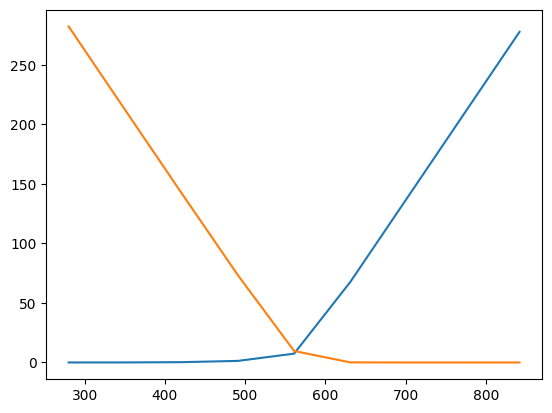

In [13]:
maturities = np.sort(np.array(dataset['days_to_maturity'].unique().tolist()))
strikes = np.sort(np.array(dataset['strike_price'].unique().tolist()))
spots = np.sort(np.array(dataset['spot_price'].unique().tolist()))
dates = np.sort(np.array(dataset['calculation_date'].unique().tolist()))
test = dataset.copy()
test = test[
        (test['averaging_type']=='geometric')&
        (test['n_fixings']==1)
        &(test['calculation_date']==dates[2])
].sort_values(by=['strike_price'])

test_puts = test[(test['w'] == 'put')][['strike_price','difference']].sort_values(by='strike_price').set_index('strike_price')
test_calls = test[(test['w'] == 'call')][['strike_price','difference']].sort_values(by='strike_price').set_index('strike_price')
plt.figure()
plt.plot(test_puts)
plt.plot(test_calls)
plt.show()
plt.close()

# Preprocessing

In [14]:
import convsklearn
categorical_features = ['averaging_type', 'w']
numerical_features = [
    'spot_price',
    'strike_price',
    'days_to_maturity',
    'risk_free_rate',
    'dividend_rate',
    'kappa',
    'theta',
    'rho',
    'eta',
    'v0',
    'fixing_frequency',
    'n_fixings',
    'past_fixings'
]
target_name = 'observed_price'
trainer = convsklearn.convsklearn(categorical_features = categorical_features, numerical_features = numerical_features, target_name = target_name)
for col in trainer.numerical_features:
    dataset[col] = pd.to_numeric(dataset[col],errors='coerce')
dataset['asian_price'] = pd.to_numeric(dataset['asian_price'],errors='coerce')
dataset['observed_price'] = ms.noisyfier(dataset['asian_price'])

## Train/test split

In [17]:
dataset['n_fixings'].unique()

array([ 1,  5, 10])

In [18]:
test_data = dataset[dataset['n_fixings']==1]
train_data = dataset[dataset['n_fixings']!=1]

In [19]:
test_data

,spot_price,strike_price,risk_free_rate,dividend_rate,w,averaging_type,fixing_frequency,n_fixings,past_fixings,kappa,theta,rho,eta,v0,calculation_date,days_to_maturity,asian_price,vanilla,difference,moneyness,observed_price
0,562.84000,281,0.04000,0.00000,call,arithmetic,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,282.76233,282.76233,1.00299,0.00000
3,562.84000,281,0.04000,0.00000,call,geometric,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,282.76233,282.76233,1.00299,0.13480
6,562.84000,281,0.04000,0.00000,put,arithmetic,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,0.00001,0.00001,-0.50075,0.00000
9,562.84000,281,0.04000,0.00000,put,geometric,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,0.00001,0.00001,-0.50075,0.00000
12,562.84000,351,0.04000,0.00000,call,arithmetic,30,1,0,0.01341,4.40126,-0.74857,1.22247,0.02730,2024-09-16,30,0.00000,212.99315,212.99315,0.60353,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,582.35000,800,0.04000,0.00000,put,geometric,30,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,30,216.04281,215.02423,-1.01859,0.37374,216.22214
2580,582.35000,873,0.04000,0.00000,call,arithmetic,30,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,30,0.00000,0.00000,0.00000,-0.33293,0.00000
2583,582.35000,873,0.04000,0.00000,call,geometric,30,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,30,0.00000,0.00000,0.00000,-0.33293,0.11079
2586,582.35000,873,0.04000,0.00000,put,arithmetic,30,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,30,288.67320,287.78458,-0.88862,0.49910,288.63045


In [20]:
test_train_ratio = int(round(100*test_data.shape[0]/train_data.shape[0],0))
print(f"train/test: {100-test_train_ratio}/{test_train_ratio}")

train/test: 50/50


In [21]:
arrs = trainer.get_train_test_arrays(
    train_data, test_data,feature_set = trainer.feature_set, target_name=trainer.target_name)
preprocessor = trainer.preprocess()
train_X = arrs['train_X'] 
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']

# Training

In [22]:
model_fit, runtime, specs = trainer.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (15, 15, 15)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

cpu: 218.489981174469


# Testing

In [23]:
test_data.describe()

,spot_price,strike_price,risk_free_rate,dividend_rate,fixing_frequency,n_fixings,past_fixings,kappa,theta,rho,eta,v0,calculation_date,days_to_maturity,asian_price,vanilla,difference,moneyness,observed_price
count,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000,864,864.00000,864.00000,864.00000,864.00000,864.00000,864.00000
mean,572.33042,571.82407,0.04000,0.00000,30.00000,1.00000,0.00000,4.91859,0.23845,-0.70585,2.44829,0.03178,2024-10-01 08:00:00,30.00000,66.77989,80.45098,13.67109,0.06458,66.81163
min,561.40000,280.00000,0.04000,0.00000,30.00000,1.00000,0.00000,0.01341,0.04171,-0.79062,1.22247,0.01068,2024-09-16 00:00:00,30.00000,0.00000,0.00000,-1.06317,-0.50160,0.00000
25%,568.52750,426.00000,0.04000,0.00000,30.00000,1.00000,0.00000,2.74658,0.04964,-0.73604,1.59202,0.02060,2024-09-23 18:00:00,30.00000,0.00000,0.01409,0.00001,-0.25086,0.00000
50%,571.38500,571.00000,0.04000,0.00000,30.00000,1.00000,0.00000,4.02345,0.05100,-0.69630,1.94467,0.03261,2024-10-01 12:00:00,30.00000,0.05250,9.48904,0.06573,0.00000,0.26761
75%,576.38250,720.25000,0.04000,0.00000,30.00000,1.00000,0.00000,7.28207,0.05741,-0.67771,3.35891,0.03929,2024-10-09 06:00:00,30.00000,141.70289,144.77186,1.34591,0.33486,141.80581
max,584.32000,876.00000,0.04000,0.00000,30.00000,1.00000,0.00000,12.42279,4.40126,-0.61937,4.66356,0.05040,2024-10-17 00:00:00,30.00000,292.35379,293.27876,286.91581,1.00643,292.31856
std,6.08253,184.92757,0.00000,0.00000,0.00000,0.00000,0.00000,3.45194,0.86868,0.04377,1.09435,0.01163,NaN,0.00000,98.77038,102.54831,50.70720,0.38041,98.74510


In [24]:
insample, outsample, errors = trainer.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )
outofsample_RMSE = errors['outofsample_RMSE']


in sample:
     RSME: 14.486829937096152
     MAE: 11.581267227032443

out of sample:
     RSME: 58.12626687339945
     MAE: 39.96430842441967


# Saving